In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 41.2 MB/s eta 0:00:00


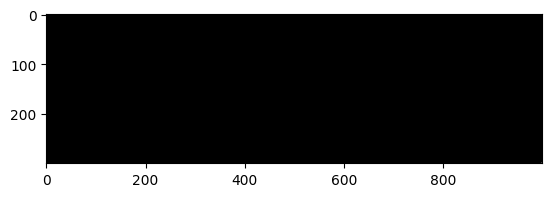

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.transform import resize
import gymnasium as gym
from gymnasium import spaces
import random

# Step 1: Generate a Random Binary Image
width, height = 100000, 30000
large_image = np.random.choice([0, 255], size=(height, width), p=[0.7, 0.3]).astype(np.uint8)

# Save the generated large image (Optional)
Image.fromarray(large_image).save('large_random_image.png')

# Step 2: Downscale the Image
downscale_width, downscale_height = 1000, 300
small_image = resize(large_image, (downscale_height, downscale_width), anti_aliasing=True, mode='reflect')
small_image = (small_image > 0.5).astype(np.uint8) * 255  # Convert to binary again

# Save the downscaled image (Optional)
Image.fromarray(small_image).save('downscaled_image.png')

# Step 3: Create a Custom Gym Environment

class GridEnv(gym.Env):
    def __init__(self, grid):
        super(GridEnv, self).__init__()
        self.grid = grid
        self.height, self.width = grid.shape
        self.action_space = spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width), dtype=np.uint8)
        self.start_pos = (0, 0)
        self.end_pos = (self.height - 1, self.width - 1)
        self.current_pos = self.start_pos

    def reset(self):
        self.current_pos = self.start_pos
        return self.grid

    def step(self, action):
        y, x = self.current_pos
        if action == 0 and y > 0:          # Up
            y -= 1
        elif action == 1 and y < self.height - 1:  # Down
            y += 1
        elif action == 2 and x > 0:        # Left
            x -= 1
        elif action == 3 and x < self.width - 1:  # Right
            x += 1

        if self.grid[y, x] == 255:  # Check if it's a white pixel (obstacle)
            reward = -1
        else:
            reward = -0.1

        self.current_pos = (y, x)
        done = self.current_pos == self.end_pos
        if done:
            reward = 100  # High reward for reaching the goal

        return self.grid, reward, done, {}

    def render(self):
        img = np.copy(self.grid)
        y, x = self.current_pos
        img[y, x] = 128  # Mark current position with a different value
        plt.imshow(img, cmap='gray')
        plt.show()

# Step 4: Train a Simple RL Agent

# Initialize environment
env = GridEnv(small_image)

# Simple Q-learning (for demonstration purposes, you might want to use a more sophisticated agent)
q_table = np.zeros((downscale_height, downscale_width, env.action_space.n))
alpha = 0.1
gamma = 0.99
epsilon = 0.1
episodes = 1000

for episode in range(episodes):
    state = env.reset()
    done = False

    while not done:
        y, x = env.current_pos

        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[y, x, :])  # Exploit

        next_state, reward, done, _ = env.step(action)
        next_y, next_x = env.current_pos
        q_table[y, x, action] = q_table[y, x, action] + alpha * (reward + gamma * np.max(q_table[next_y, next_x, :]) - q_table[y, x, action])

    # Decay epsilon (optional)
    epsilon = max(0.01, epsilon * 0.995)

# Render the final path
env.render()


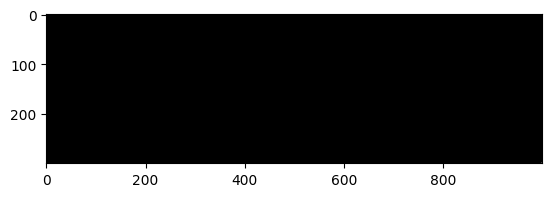

In [ ]:
env.render()


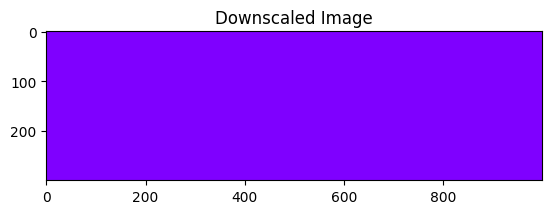

In [ ]:
plt.imshow(small_image, cmap='rainbow')
plt.title("Downscaled Image")
plt.show()


In [ ]:
import numpy as np

width, height = 1000, 300
large_matrix = np.random.choice([0, 1], size=(height, width), p=[0.3, 0.7])

print(large_matrix)


[[1 0 0 ... 0 1 1]
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 0 0]
 ...
 [1 1 0 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 0 1]]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

# Define the Q-Network
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# DQL Agent
class DQLAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64
        self.model = DQNetwork(state_size, action_size).to(device)
        self.target_model = DQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.update_target_network()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        act_values = self.model(state)
        return torch.argmax(act_values[0]).item()

    def update_replay_buffer(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_from_replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * torch.max(self.target_model(torch.FloatTensor(next_state).to(device))).item()
            target_f = self.model(torch.FloatTensor(state).to(device))
            target_f[action] = target
            self.model.train()
            self.optimizer.zero_grad()
            loss = nn.functional.mse_loss(self.model(torch.FloatTensor(state).to(device)), target_f)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Utility function to move in the grid based on action
def move(state, action):
    if action == 0:  # up
        return np.array([state[0], max(state[1] - 1, 0)])
    elif action == 1:  # down
        return np.array([state[0], min(state[1] + 1, height - 1)])
    elif action == 2:  # left
        return np.array([max(state[0] - 1, 0), state[1]])
    else:  # right
        return np.array([min(state[0] + 1, width - 1), state[1]])

# Training Loop
def train_dql(agent, episodes):
    safe_paths = []
    for episode in range(episodes):
        state = np.array([0, 0])
        total_reward = 0
        path = [state.tolist()]

        for t in range(10000):
            action = agent.choose_action(state)
            next_state = move(state, action)

            reward = 1 if grid[next_state[1], next_state[0]] == 1 else -100
            total_reward += reward
            done = (next_state[0] == width - 1 and next_state[1] == height - 1) or (reward == -100)

            agent.update_replay_buffer(state, action, reward, next_state, done)
            agent.train_from_replay()

            state = next_state
            path.append(state.tolist())

            if done:
                if reward != -100:
                    safe_paths.append(path)
                    print(path)
                break

    print("DQL training completed.")
    print("Safe paths found by DQL:")
    for path in safe_paths:
        print(path)

# Initialize and run DQL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_size = 2
action_size = 4
episodes = 10  # Adjust this based on your needs

# Generate the grid (make sure to generate it outside the training function)
width, height = 100, 300
grid = np.random.choice([0, 1], size=(height, width), p=[0.005, 0.995])

dql_agent = DQLAgent(state_size, action_size)
train_dql(dql_agent, episodes)


KeyboardInterrupt: 

In [ ]:
grid = np.random.choice([0, 1], size=(height, width), p=[0.2, 0.8])

In [ ]:
grid

array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 1, 1],
       [1, 1, 1, 1]])

In [ ]:
[[0, 0], [0, 1], [1, 1], [1, 2], [1, 3], [0, 3], [1, 3], [1, 2], [2, 2], [2, 3], [3, 3]]


[[0, 0], [1, 0], [1, 1], [2, 1], [2, 2], [3, 2], [3, 2], [3, 3]]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

width, height = 4, 4
grid = np.random.choice([0, 1], size=(height, width), p=[0.1, 0.9])

print("Grid:")
print(grid)

# Function to move to the next state based on action
def move(state, action):
    if action == 0:  # Up
        next_state = [state[0], max(state[1] - 1, 0)]
    elif action == 1:  # Down
        next_state = [state[0], min(state[1] + 1, height - 1)]
    elif action == 2:  # Left
        next_state = [max(state[0] - 1, 0), state[1]]
    elif action == 3:  # Right
        next_state = [min(state[0] + 1, width - 1), state[1]]
    return next_state

# A3C Network
class A3CNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(A3CNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.actor = nn.Linear(128, action_size)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.actor(x), dim=-1), self.critic(x)

# A3C Agent
class A3CAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.network = A3CNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.001)
        self.gamma = 0.99

    def choose_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs, _ = self.network(state)
        action = torch.multinomial(action_probs, 1).item()
        return action

    def optimize(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)

        _, value = self.network(state)
        _, next_value = self.network(next_state)

        target = reward + (1 - done) * self.gamma * next_value
        advantage = target - value

        self.optimizer.zero_grad()
        loss = advantage.pow(2).mean()
        loss.backward()
        self.optimizer.step()

# Training Loop
def worker(agent):
    safe_paths = []
    for episode in range(episodes):
        state = np.array([0, 0])
        total_reward = 0
        path = [state.tolist()]

        for t in range(100):
            action = agent.choose_action(state)
            next_state = move(state, action)

            reward = 1 if grid[next_state[1], next_state[0]] == 1 else -100
            total_reward += reward
            done = (next_state[0] == width - 1 and next_state[1] == height - 1) or (reward == -100)

            agent.optimize(state, action, reward, next_state, done)

            state = next_state
            path.append(state)

            if done:
                if reward != -100:
                    safe_paths.append(path)
                break

    print("A3C training completed.")
    print("Safe paths found by A3C:")
    for path in safe_paths:
        print(path)

# Initialize and run A3C
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_size = 2
action_size = 4
episodes = 100  # Adjust this based on your needs

a3c_agent = A3CAgent(state_size, action_size)
worker(a3c_agent)


Grid:
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
A3C training completed.
Safe paths found by A3C:
[[0, 0], [1, 0], [0, 0], [1, 0], [0, 0], [1, 0], [0, 0], [1, 0], [1, 0], [1, 1], [2, 1], [2, 0], [2, 1], [3, 1], [3, 2], [3, 2], [3, 3]]
[[0, 0], [0, 1], [0, 2], [0, 2], [0, 3], [0, 2], [0, 1], [0, 0], [0, 0], [0, 0], [1, 0], [0, 0], [1, 0], [1, 0], [0, 0], [0, 0], [0, 0], [0, 1], [0, 1], [1, 1], [2, 1], [2, 0], [2, 1], [1, 1], [1, 2], [2, 2], [1, 2], [2, 2], [3, 2], [2, 2], [2, 3], [3, 3]]
[[0, 0], [0, 1], [0, 2], [0, 3], [1, 3], [1, 3], [2, 3], [2, 2], [2, 3], [1, 3], [1, 3], [0, 3], [0, 3], [1, 3], [2, 3], [3, 3]]
[[0, 0], [1, 0], [1, 1], [0, 1], [0, 1], [0, 2], [0, 2], [0, 3], [0, 3], [0, 2], [1, 2], [1, 1], [0, 1], [1, 1], [0, 1], [0, 1], [1, 1], [0, 1], [0, 2], [0, 2], [0, 1], [0, 1], [0, 2], [0, 2], [1, 2], [2, 2], [3, 2], [3, 2], [3, 1], [2, 1], [3, 1], [2, 1], [3, 1], [2, 1], [2, 0], [1, 0], [2, 0], [2, 1], [2, 2], [1, 2], [1, 3], [0, 3], [1, 3], [0, 3], [0, 3], [0, 2], [1, 2], 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

width, height = 4, 4
grid = np.random.choice([0, 1], size=(height, width), p=[0.1, 0.9])

# PPO Network
class PPOActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(PPOActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.actor = nn.Linear(128, action_size)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.actor(x), dim=-1), self.critic(x)

# PPO Agent
class PPOAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.network = PPOActorCritic(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.001)
        self.gamma = 0.99
        self.eps_clip = 0.2

    def choose_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs, _ = self.network(state)
        action = torch.multinomial(action_probs, 1).item()
        return action

    def optimize(self, states, actions, rewards, dones, next_states):
        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        actions = torch.LongTensor(actions).to(device)

        _, values = self.network(states)
        _, next_values = self.network(next_states)

        # Convert lists to tensors for numerical operations
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        advantages = rewards + (1 - dones) * self.gamma * next_values - values

        # Compute PPO loss
        action_probs, _ = self.network(states)
        old_action_probs = action_probs.gather(1, actions.unsqueeze(1))
        ratio = torch.exp(torch.log(old_action_probs) - torch.log(action_probs))
        surrogate1 = ratio * advantages
        surrogate2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

        self.optimizer.zero_grad()
        loss = -torch.min(surrogate1, surrogate2).mean()
        loss.backward()
        self.optimizer.step()

# Training Loop
def train_ppo(agent, episodes):
    safe_paths = []
    for episode in range(episodes):
        state = np.array([0, 0])
        total_reward = 0
        path = [state.tolist()]
        states, actions, rewards, dones, next_states = [], [], [], [], []

        for t in range(10000):
            action = agent.choose_action(state)
            next_state = move(state, action)

            reward = 1 if grid[next_state[1], next_state[0]] == 1 else -100
            total_reward += reward
            done = (next_state[0] == width - 1 and next_state[1] == height - 1) or (reward == -100)

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            next_states.append(next_state)

            state = next_state
            path.append(state)

            if done:
                if reward != -100:
                    safe_paths.append(path)
                break

        agent.optimize(states, actions, rewards, dones, next_states)

    print("PPO training completed.")
    print("Safe paths found by PPO:")
    for path in safe_paths:
        print(path)

# Initialize and run PPO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_size = 2
action_size = 4
episodes = 100 # Adjust this based on your needs

ppo_agent = PPOAgent(state_size, action_size)
train_ppo(ppo_agent, episodes)


<ipython-input-6-82d72e20061d>:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  states = torch.FloatTensor(states).to(device)


PPO training completed.
Safe paths found by PPO:
[[0, 0], array([1, 0]), array([0, 0]), array([0, 1]), array([1, 1]), array([2, 1]), array([2, 2]), array([3, 2]), array([3, 3])]
[[0, 0], array([0, 0]), array([0, 0]), array([0, 1]), array([0, 1]), array([1, 1]), array([1, 2]), array([2, 2]), array([2, 1]), array([3, 1]), array([3, 2]), array([3, 3])]
[[0, 0], array([0, 0]), array([1, 0]), array([1, 0]), array([1, 1]), array([1, 0]), array([1, 0]), array([1, 0]), array([1, 0]), array([0, 0]), array([0, 0]), array([0, 1]), array([0, 2]), array([0, 2]), array([1, 2]), array([0, 2]), array([1, 2]), array([1, 1]), array([2, 1]), array([2, 0]), array([1, 0]), array([1, 0]), array([1, 0]), array([1, 0]), array([1, 0]), array([1, 1]), array([2, 1]), array([3, 1]), array([3, 0]), array([3, 0]), array([2, 0]), array([2, 1]), array([2, 2]), array([2, 3]), array([3, 3])]
[[0, 0], array([0, 1]), array([1, 1]), array([2, 1]), array([3, 1]), array([3, 2]), array([3, 3])]
[[0, 0], array([0, 0]), array(

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

width, height = 4, 4
grid = np.random.uniform(0, 1, size=(height, width))

# PPO Network
class PPOActorCritic(nn.Module):
    def __init__(self, state_size, action_size):
        super(PPOActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.actor = nn.Linear(128, action_size)
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.actor(x), dim=-1), self.critic(x)

# PPO Agent
class PPOAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.network = PPOActorCritic(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.network.parameters(), lr=0.001)
        self.gamma = 0.99
        self.eps_clip = 0.2

    def choose_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action_probs, _ = self.network(state)
        action = torch.multinomial(action_probs, 1).item()
        return action

    def optimize(self, states, actions, rewards, dones, next_states):
        states = torch.FloatTensor(states).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        actions = torch.LongTensor(actions).to(device)

        _, values = self.network(states)
        _, next_values = self.network(next_states)

        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        advantages = rewards + (1 - dones) * self.gamma * next_values - values

        action_probs, _ = self.network(states)
        old_action_probs = action_probs.gather(1, actions.unsqueeze(1))
        ratio = torch.exp(torch.log(old_action_probs) - torch.log(action_probs))
        surrogate1 = ratio * advantages
        surrogate2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

        self.optimizer.zero_grad()
        loss = -torch.min(surrogate1, surrogate2).mean()
        loss.backward()
        self.optimizer.step()

# Training Loop
def train_ppo(agent, episodes):
    val = np.inf
    smol_pth = []
    safe_paths = []
    for episode in range(episodes):
        state = np.array([0, 0])
        total_reward = 0
        path = [state.tolist()]
        states, actions, rewards, dones, next_states = [], [], [], [], []

        for t in range(10000):
            action = agent.choose_action(state)
            next_state = move(state, action)

            reward = grid[next_state[1], next_state[0]] * 10 - 5  # Adjust reward calculation
            total_reward += reward
            done = (next_state[0] == width - 1 and next_state[1] == height - 1) or (reward == -100)

            states.append(state)
            actions.append(action)
            rewards.append(reward)
            dones.append(done)
            next_states.append(next_state)

            state = next_state
            path.append(state.tolist())

            if done:
                if reward > 0:
                    safe_paths.append(path)
                    val = min(val, len(path))
                    if val == len(path):
                      smol_pth = path
                break

        agent.optimize(states, actions, rewards, dones, next_states)

    print("PPO training completed.")
    print("Safe paths found by PPO:")
    for path in safe_paths:
        print(path)
    print(val, smol_pth)

# Initialize and run PPO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_size = 2
action_size = 4
episodes = 100 # Adjust this based on your needs

print(grid)
ppo_agent = PPOAgent(state_size, action_size)
train_ppo(ppo_agent, episodes)


[[0.8549989  0.3957353  0.58909574 0.75769797]
 [0.65065802 0.54364441 0.59566038 0.22775051]
 [0.61308822 0.76244919 0.47868549 0.36891298]
 [0.21966828 0.4473615  0.03856421 0.65310152]]


<ipython-input-17-8708c1200ad6>:48: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.FloatTensor(dones).unsqueeze(1).to(device)


PPO training completed.
Safe paths found by PPO:
[[0, 0], [1, 0], [1, 1], [0, 1], [0, 2], [0, 2], [0, 3], [0, 3], [1, 3], [1, 3], [2, 3], [2, 2], [1, 2], [0, 2], [1, 2], [1, 1], [2, 1], [2, 0], [2, 1], [2, 0], [2, 1], [1, 1], [1, 0], [2, 0], [3, 0], [3, 1], [3, 1], [2, 1], [2, 2], [1, 2], [2, 2], [2, 3], [1, 3], [0, 3], [0, 3], [1, 3], [0, 3], [0, 3], [0, 3], [1, 3], [1, 2], [1, 1], [2, 1], [2, 2], [3, 2], [3, 3]]
[[0, 0], [0, 0], [1, 0], [0, 0], [0, 1], [0, 1], [0, 1], [0, 0], [0, 0], [1, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 0], [0, 0], [0, 0], [1, 0], [1, 1], [2, 1], [3, 1], [2, 1], [1, 1], [1, 2], [1, 1], [1, 2], [1, 1], [1, 2], [2, 2], [2, 3], [2, 3], [2, 2], [2, 1], [2, 2], [1, 2], [2, 2], [2, 1], [2, 0], [3, 0], [2, 0], [2, 1], [2, 2], [1, 2], [2, 2], [3, 2], [2, 2], [2, 3], [2, 3], [1, 3], [2, 3], [2, 2], [2, 1], [3, 1], [3, 2], [3, 2], [3, 2], [2, 2], [2, 3], [2, 3], [1, 3], [0, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 3], [2, 3], [2, 2], [2, 3], [1, 3], [0, 3], [0, 3], [0, 3